# Cosine Similarity of Whole Document

In [29]:
import numpy as np
import pandas as pd
from scipy import stats
import requests
import pickle
import datetime
import h5py
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

Fix the files such that they don't take up more space than necessary

In [30]:
# Import the Cosine Scores
#with open('../Step2-Signal/1-whole_doc_scores.pickle', 'rb') as f:
#    parsed = pickle.load(f)

In [31]:
# Remove the Items, we don't need them for this notebook
#pruned_parsed = {}

#for company in parsed.keys():
#    pruned_parsed[company] = parsed[company].loc[:, 
#                             [x for x in parsed[company].columns if x not in ['Item1', 'Item1a', 'Item7']]]
    
#with open('pruned_parsed.pickle', 'wb') as handle:
#    pickle.dump(pruned_parsed, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
parsed = pickle.load(open('pruned_parsed.pickle', 'rb'))

In [37]:
# Flatten into a single df
df = pd.concat(parsed, axis=0).reset_index()
#df.head()

In [38]:
# Add missing column names
df.columns = ['company', 'doc_idx'] + list(df.columns[2:])
df.head()

,company,doc_idx,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,Link,Cos_Sim_All
0,0001090872,68,0001090872-20-000020,2020-12-18,2020-10-31,2020-12-17T19:56:21.000Z,34,10-K,001-15405,201397647,,21881479.0,1.0,1.0,a-20201031.htm,10-K,https://www.sec.gov/Archives/edgar/data/109087...,0.974555
1,0001090872,189,0001090872-19-000022,2019-12-19,2019-10-31,2019-12-19T17:11:01.000Z,34,10-K,001-15405,191296602,,24913824.0,1.0,1.0,a-10312019x10k.htm,10-K,https://www.sec.gov/Archives/edgar/data/109087...,0.979081
2,0001090872,294,0001090872-18-000019,2018-12-20,2018-10-31,2018-12-20T16:27:07.000Z,34,10-K,001-15405,181246492,,20762678.0,1.0,0.0,a-10312018x10k.htm,10-K,https://www.sec.gov/Archives/edgar/data/109087...,0.991900
3,0001090872,371,0001090872-17-000018,2017-12-21,2017-10-31,2017-12-21T16:27:19.000Z,34,10-K,001-15405,171269747,,20916622.0,1.0,0.0,a-10312017x10k.htm,10-K,https://www.sec.gov/Archives/edgar/data/109087...,0.991373
4,0001090872,469,0001090872-16-000082,2016-12-20,2016-10-31,2016-12-20T16:22:19.000Z,34,10-K,001-15405,162061597,,21686586.0,1.0,0.0,a-10312016x10k.htm,10-K,https://www.sec.gov/Archives/edgar/data/109087...,0.990578


In [39]:
# Convert filing date to datetime and sort on filing date
df['filingDate'] = pd.to_datetime(df['filingDate'])
df = df.sort_values(['filingDate'])

In [40]:
# Get Returns
rets = pd.read_hdf('../Step1-Data/1-rets.h5')
rets.tail()

,A,AABA,AAL,AAMRQ,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,...,XRX,XTO,XYL,YNR,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
2021-08-02,-0.001044,NaN,-0.015702,NaN,0.003065,-0.002331,-0.007309,0.004584,NaN,NaN,...,NaN,NaN,-0.001669,NaN,NaN,0.007611,-0.002509,-0.002733,-0.009971,-0.002911
2021-08-03,0.005161,NaN,-0.005483,NaN,0.012646,0.012644,0.006929,0.007985,NaN,NaN,...,NaN,NaN,0.018227,NaN,NaN,0.007780,-0.057052,-0.007677,0.021499,0.009846
2021-08-04,0.002665,NaN,-0.025063,NaN,-0.026602,-0.002782,-0.010065,0.014874,NaN,NaN,...,NaN,NaN,-0.009927,NaN,NaN,0.000750,-0.035652,0.024253,-0.009670,0.003381
2021-08-05,0.004991,NaN,0.075064,NaN,-0.015882,0.000749,0.000348,-0.029152,NaN,NaN,...,NaN,NaN,0.006790,NaN,NaN,0.000899,0.013088,0.016464,0.017040,-0.004639
2021-08-06,0.004257,NaN,0.005261,NaN,-0.003005,-0.004767,-0.005820,-0.010255,NaN,NaN,...,NaN,NaN,0.010038,NaN,NaN,0.002918,-0.007791,-0.012210,0.035203,-0.009615


In [41]:
# Delete the stocks that we know have data issues (see below)
badslist = ['ACS','AYE','BDK','BOL','BLS','BSC',
            'CBE','CFC','FBF','HIG','MEE',
            'ROH','RX','SOV','TEK','TIE']

#rets = rets.loc[:,[x for x in rets.columns if x not in badslist]]

In [42]:
# Verify number of stocks listed
rets.count(axis=1).tail()

2021-08-02    503
2021-08-03    503
2021-08-04    503
2021-08-05    503
2021-08-06    503
dtype: int64

<AxesSubplot:>

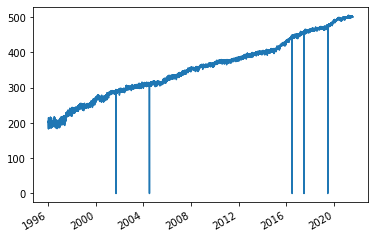

In [43]:
# Sanity check on returns, see if anything seems weird
temp = (rets / rets).sum(axis=1)
temp.plot()

In [44]:
# Why are there drop offs? 
temp[temp < 100]

2001-09-12    0.0
2001-09-13    0.0
2004-07-05    0.0
2016-07-04    0.0
2017-07-04    0.0
2019-07-04    0.0
dtype: float64

In [45]:
rets.loc['2001-09-12'].dropna()

A       0.0
AAPL    0.0
ABC     0.0
ABT     0.0
ADBE    0.0
       ... 
XOM     0.0
XRX     0.0
YUM     0.0
ZBH     0.0
ZION    0.0
Name: 2001-09-12 00:00:00, Length: 306, dtype: float64

For some reason, there are some holiday/market closures that are included in this dataset. July 4 is independence day in America, so markets are generally closed. Similarly, markets were closed in the aftermath of 9\/11

In [46]:
bad_dates = temp[temp < 100].index

# Remove those dates
rets = rets.loc[[x for x in rets.index if x not in bad_dates]]

In [47]:
# Sanity check
'2001-09-12' in rets.index

False

# Keep Going...

In [48]:
# Concatenate all the scores into a single dataframe
scores_df = pd.DataFrame([], index=rets.index)
companies = list(parsed.keys())
companies2 = []

for company in companies:
    # Todo
    # Some companies have two of the same filing date, 
    # however this is very rare
    try:
        temp = parsed[company].copy().dropna(axis=0)
        temp.loc[:,'filingDate'] = pd.to_datetime(temp.loc[:,'filingDate'])
        temp = temp.set_index('filingDate').loc[:,'Cos_Sim_All'].copy()
        scores_df = pd.concat([scores_df, temp], axis=1)
        companies2.append(company)
    except:
        continue

In [49]:
# Rename the columns
scores_df.columns = companies2

# Remove bads
scores_df = scores_df.loc[:, [x for x in scores_df.columns if x not in badslist]]

# Remove up to August 6 #ToDO
scores_df = scores_df.loc[:'2021-08-06']

# These are the companies that filed on the last few days
scores_df.tail().dropna(axis=1, how='all')

,0000008670,0000319201,0000080424,0001137789
2021-08-02,NaN,NaN,NaN,NaN
2021-08-03,NaN,NaN,NaN,NaN
2021-08-04,0.991825,NaN,NaN,NaN
2021-08-05,NaN,NaN,NaN,NaN
2021-08-06,NaN,0.989907,0.988463,0.983665


<AxesSubplot:>

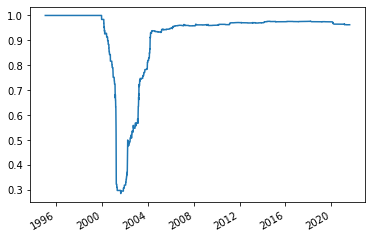

In [50]:
# See how the average cosine similarity changes over time
scores_df.ffill().mean(axis=1).plot()

# Calculate Returns over Horizons

In [51]:
# Calculate returns for each stock over each horizon 
# (in days)
horizon_list = [5, 10, 21, 42, 63, 120, 180, 240]

In [52]:
rets_horizon_dict = {}
for horizon in horizon_list:
    print(horizon)
    df5= pd.DataFrame()
    #for i in range(len(rets) - horizon -1):
        #print(i)
    df5 = temp = (1+rets).rolling(str(horizon) + 'D').apply(np.prod, raw=True) - 1
    rets_horizon_dict[horizon] = df5.copy()

5
10
21
42
63
120
180
240


In [68]:
# Save as pickle
with open('1-horizon_rets_wholedoc.pickle', 'wb') as handle:
    pickle.dump(rets_horizon_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
# Read pickle to save time by not having to calculate
# rets_horizon_dict each time
rets_horizon_dict = pd.read_pickle('1-horizon_rets_wholedoc.pickle')

In [55]:
# Read csv to prepare CIK -> ticker mapping
#mapping = pd.read_csv("../Step1-Data/1-valid_tickers.csv")
#mapping.head()

In [56]:
# New mapping, mapping above is not as good
mapping = pd.read_csv("../Step1-Data/2-new_mapping.csv")
mapping.columns = ['Ticker', 'CIK']
mapping

,Ticker,CIK
0,A,0001090872
1,AABA,0001011006
2,AAL,0000006201
3,AAMRQ,0000006201
4,AAP,0001158449
...,...,...
1105,YUM,0001041061
1106,ZBH,0001136869
1107,ZBRA,0000877212
1108,ZION,0000109380


# Correlations w/ No Sector Demeaning

In [57]:
# One-horizon example
return_over_horizon = rets_horizon_dict[5].rank(axis=1)
return_over_horizon.tail()

,A,AABA,AAL,AAMRQ,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,...,XRX,XTO,XYL,YNR,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
2021-08-02,341.0,NaN,8.0,NaN,254.0,272.0,46.0,356.0,NaN,NaN,...,NaN,NaN,420.0,NaN,NaN,497.0,263.0,329.0,95.0,160.0
2021-08-03,298.0,NaN,17.0,NaN,312.0,339.0,71.0,301.0,NaN,NaN,...,NaN,NaN,411.0,NaN,NaN,415.0,19.0,180.0,183.0,208.0
2021-08-04,333.0,NaN,39.0,NaN,178.0,339.0,182.0,463.0,NaN,NaN,...,NaN,NaN,326.0,NaN,NaN,416.0,6.0,395.0,280.0,369.0
2021-08-05,298.0,NaN,410.0,NaN,60.0,268.0,131.0,182.0,NaN,NaN,...,NaN,NaN,313.0,NaN,NaN,345.0,11.0,433.0,363.0,245.0
2021-08-06,318.0,NaN,396.0,NaN,49.0,197.0,88.0,102.0,NaN,NaN,...,NaN,NaN,363.0,NaN,NaN,343.0,8.0,329.0,476.0,140.0


In [58]:
# Forward fill the scores, rename the columns to tickers
vanilla_score = scores_df.ffill()
vanilla_score.columns = [mapping[mapping['CIK'] == x]['Ticker'].values[0] for x in vanilla_score.columns]

# Mask according to returns
masked_vanilla_score = vanilla_score.where(~rets.isna(), np.nan).ffill()

In [59]:
rets.index

DatetimeIndex(['1996-01-02', '1996-01-03', '1996-01-04', '1996-01-05',
               '1996-01-08', '1996-01-09', '1996-01-10', '1996-01-11',
               '1996-01-12', '1996-01-15',
               ...
               '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29',
               '2021-07-30', '2021-08-02', '2021-08-03', '2021-08-04',
               '2021-08-05', '2021-08-06'],
              dtype='datetime64[ns]', length=6445, freq=None)

In [60]:
# Sanity Check on XOM
parsed['0000034088']['Cos_Sim_All']

274    0.974540
431    0.984036
524    0.994871
624    0.993609
745    0.995740
877         NaN
Name: Cos_Sim_All, dtype: float64

In [61]:
# Should match the above scores
masked_vanilla_score['XOM'].dropna()

2017-02-22    0.99574
2017-02-23    0.99574
2017-02-24    0.99574
2017-02-27    0.99574
2017-02-28    0.99574
               ...   
2021-08-02    0.97454
2021-08-03    0.97454
2021-08-04    0.97454
2021-08-05    0.97454
2021-08-06    0.97454
Name: XOM, Length: 1125, dtype: float64

In [62]:
# Should be all True
~rets.isna()['XOM'].dropna()

1996-01-02    True
1996-01-03    True
1996-01-04    True
1996-01-05    True
1996-01-08    True
              ... 
2021-08-02    True
2021-08-03    True
2021-08-04    True
2021-08-05    True
2021-08-06    True
Name: XOM, Length: 6445, dtype: bool

In [63]:
ranked_vanilla_score = masked_vanilla_score.rank(axis=1)

<AxesSubplot:>

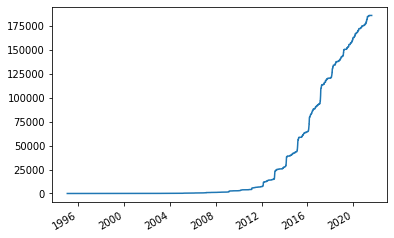

In [64]:
ranked_vanilla_score.sum(axis=1).plot()

In [65]:
return_over_horizon.corrwith(ranked_vanilla_score, axis=1).dropna().mean()

0.0019831338700806184

In [66]:
# Calculate correlation over each horizon
risk_factor_graph = []
for horizon in horizon_list:
    
    return_over_horizon = rets_horizon_dict[horizon].rank(axis=1)
    
    return_over_horizon = return_over_horizon.loc[:,ranked_vanilla_score.columns]
    
    val  = return_over_horizon.corrwith(ranked_vanilla_score.loc[return_over_horizon.index], 
                                        axis=1).dropna().mean()
    
    risk_factor_graph.append([horizon, val])

In [67]:
risk_factor_df1 = pd.DataFrame(risk_factor_graph,columns=['Horizon (Days)', 'Corr(Score, Returns)'])
risk_factor_df1

,Horizon (Days),"Corr(Score, Returns)"
0,5,0.001983
1,10,0.004032
2,21,0.002278
3,42,0.002993
4,63,0.008200
5,120,0.016601
6,180,0.026261
7,240,0.045473


# Subtract the Ranks by Clusters

In [69]:
# Import the scores
clusters = pd.read_csv('../Step1-Data/cluster_scores.csv')
clusters

,filingDate,0000029924,0000736260,0001047699,0000732485,0000803014,0000944314,0000726513,0000873364,0001021860,...,0001800227,0000070858,0000886982,0001364742,0000019617,0001799208,0001823340,0001798562,0001828325,0001413447
0,2003-06-03,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-06-02,3.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-05-27,3.0,1.0,1.0,4.0,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-06-05,20.0,12.0,7.0,1.0,3.0,6.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-05-31,20.0,5.0,6.0,7.0,3.0,13.0,11.0,6.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2008-05-29,16.0,7.0,1.0,1.0,8.0,12.0,20.0,13.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009-06-04,18.0,7.0,3.0,4.0,8.0,7.0,14.0,4.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2010-06-02,9.0,10.0,1.0,5.0,3.0,11.0,14.0,5.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2011-06-02,19.0,13.0,1.0,1.0,18.0,18.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2012-05-31,15.0,3.0,7.0,7.0,5.0,14.0,10.0,1.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Reindex to filing date
clusters = clusters.set_index('filingDate')

# Convert to DateTime
clusters.index = pd.to_datetime(clusters.index)

# Rename CIK -> Ticker
clusters.columns = [mapping[mapping['CIK'] == x]['Ticker'].values[0] for x in clusters.columns]

# Rearrange alphabetically
clusters = clusters.reindex(sorted(clusters.columns), axis=1)
clusters

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
filingDate,,,,,,,,,,,,,,,,,,,,,
2003-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,14.0,NaN,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20.0,NaN,...,NaN,NaN,17.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2010-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,18.0,NaN,...,NaN,NaN,16.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
2011-06-02,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8.0,14.0,...,NaN,NaN,11.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN


In [71]:
# Reindex and forward fill
clusters = clusters.reindex(scores_df.index, method='ffill')
clusters.tail()

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
2021-08-02,5.0,16.0,15.0,2.0,20.0,3.0,4.0,3.0,19.0,1.0,...,20.0,5.0,17.0,5.0,9.0,20.0,7.0,5.0,13.0,7.0
2021-08-03,5.0,16.0,15.0,2.0,20.0,3.0,4.0,3.0,19.0,1.0,...,20.0,5.0,17.0,5.0,9.0,20.0,7.0,5.0,13.0,7.0
2021-08-04,5.0,16.0,15.0,2.0,20.0,3.0,4.0,3.0,19.0,1.0,...,20.0,5.0,17.0,5.0,9.0,20.0,7.0,5.0,13.0,7.0
2021-08-05,5.0,16.0,15.0,2.0,20.0,3.0,4.0,3.0,19.0,1.0,...,20.0,5.0,17.0,5.0,9.0,20.0,7.0,5.0,13.0,7.0
2021-08-06,5.0,16.0,15.0,2.0,20.0,3.0,4.0,3.0,19.0,1.0,...,20.0,5.0,17.0,5.0,9.0,20.0,7.0,5.0,13.0,7.0


In [76]:
# Sanity check, makes sense
temp = clusters.loc['2021-08-06']
temp[clusters.loc['2021-08-06'] == 7].index


Index(['AGN', 'AMGN', 'BAX', 'BIIB', 'BIO', 'BMET', 'BMY', 'BSX', 'CFN', 'CHD',
       'CL', 'COTY', 'COV', 'ENDP', 'EW', 'GENZ', 'HAS', 'HOLX', 'HSP', 'KATE',
       'KG', 'LLY', 'MDT', 'MNK', 'MYL', 'PFE', 'PRGO', 'RMD', 'STJ', 'SYK',
       'SYY', 'TFX', 'VTRS', 'WYE', 'ZBH', 'ZTS'],
      dtype='object')

In [77]:
# Add back missing columns that weren't clustered
# Use vanilla score because we need vanilla score to create
# our signals
clusters = clusters.reindex(columns=vanilla_score.columns)

In [78]:
# Fill NaNs with zeros--when we subtract these from vanilla_score
# It will mask any stocks that do not have any scores listed
clusters = clusters.fillna(0)

# Remove Cluster Mean from Cosine Similarity

In [82]:
date = ['2021-08-06']

In [83]:
vanilla_score.loc[date]

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
2021-08-06,0.974555,0.990197,0.89988,0.951777,0.989309,0.970752,0.9855,0.856398,0.933254,0.987718,...,0.968707,0.957979,0.974888,0.975175,0.953134,0.964333,0.98955,0.979149,0.971568,0.99156


In [84]:
clusters.loc[date]

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
2021-08-06,5.0,16.0,15.0,2.0,20.0,3.0,4.0,3.0,19.0,1.0,...,20.0,5.0,17.0,5.0,9.0,20.0,7.0,5.0,13.0,7.0


In [85]:
temp = vanilla_score.loc[date]
pd.DataFrame(temp.values[(clusters.loc[date] == 7).values]).dropna().mean()

0    0.951767
dtype: float64

In [86]:
cluster_score = pd.DataFrame()

for date in clusters.index:
#for date in ffilled.index:
    to_avg = vanilla_score.loc[date].groupby(clusters.loc[date].values).mean()
    cluster_score = pd.concat([cluster_score,clusters.loc[date].map(to_avg)],axis=1)

In [87]:
# Ensure that zero is included as a cluster
to_avg

0.0     0.952716
1.0     0.979376
2.0     0.965079
3.0     0.966572
4.0     0.975228
5.0     0.973114
6.0     0.966691
7.0     0.951767
8.0     0.971673
9.0     0.970301
10.0    0.947594
11.0    0.959587
12.0    0.951910
13.0    0.938189
14.0    0.970442
15.0    0.952637
16.0    0.979451
17.0    0.931996
18.0    0.945814
19.0    0.946168
20.0    0.971503
Name: 2021-08-06 00:00:00, dtype: float64

In [88]:
# ZTS belongs to cluster 7 and it matches the sanity check we did above
cluster_score.T.loc[date]

A       0.973114
AABA    0.979451
AAL     0.952637
AAP     0.965079
AAPL    0.971503
          ...   
YUM     0.971503
ZBH     0.951767
ZBRA    0.973114
ZION    0.938189
ZTS     0.951767
Name: 2021-08-06 00:00:00, Length: 983, dtype: float64

In [89]:
cluster_score = cluster_score.T

In [90]:
# Nineteen years of cosine similarity scores and 904 companies that were
# given a cluster number
np.shape(cluster_score)

(6469, 983)

In [91]:
# Add back the missing columns that were not assigned a cluster
np.shape(cluster_score)

(6469, 983)

In [92]:
avg_score = vanilla_score.mean(axis=1)

In [93]:
# Fill in NaNs with market avg for each date
for date in cluster_score.index:
    cluster_score.loc[date] = cluster_score.loc[date].fillna(avg_score.loc[date])

In [94]:
cluster_score

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1995-01-25,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1995-02-27,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1995-03-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1995-03-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1995-03-24,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,0.973017,0.979451,0.952637,0.965079,0.971503,0.966165,0.975228,0.966165,0.946168,0.979376,...,0.971503,0.973017,0.931996,0.973017,0.970089,0.971503,0.951767,0.973017,0.938189,0.951767
2021-08-03,0.973017,0.979451,0.952637,0.965079,0.971503,0.966165,0.975228,0.966165,0.946168,0.979376,...,0.971503,0.973017,0.931996,0.973017,0.970089,0.971503,0.951767,0.973017,0.938189,0.951767
2021-08-04,0.973017,0.979451,0.952637,0.965079,0.971503,0.966165,0.975228,0.966165,0.946168,0.979376,...,0.971503,0.973017,0.931996,0.973017,0.970301,0.971503,0.951767,0.973017,0.938189,0.951767
2021-08-05,0.973017,0.979451,0.952637,0.965079,0.971503,0.966165,0.975228,0.966165,0.946168,0.979376,...,0.971503,0.973017,0.931996,0.973017,0.970301,0.971503,0.951767,0.973017,0.938189,0.951767


In [95]:
#cluster_avg.columns = [mapping[mapping['CIK'] == float(x)]['Ticker'].values[0] for x in avg_df.columns]
#cluster_score = cluster_score.reindex(vanilla_score.index, method='ffill')
#cluster_score

## Cluster Avg Return

In [96]:
temp_rets = rets.loc[:, [mapping[mapping['CIK'] == x]['Ticker'].values[0] for x in scores_df.columns]]
#temp_rets.columns = companies
temp_rets.head()

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1996-01-02,NaN,NaN,NaN,NaN,0.007843,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.003650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.000915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,NaN,NaN,NaN,NaN,-0.017508,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.021082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,NaN,NaN,NaN,NaN,0.085150,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.011236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,NaN,NaN,NaN,NaN,0.010948,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
cluster_price = pd.DataFrame()

ffilled = temp_rets
ffilled.index = pd.to_datetime(ffilled.index)

# Find the average return for each cluster for each date
for date in temp_rets.index:
    to_avg = ffilled.loc[date].groupby(clusters.loc[date].values).mean()
    cluster_price = pd.concat([cluster_price, clusters.loc[date].map(to_avg)],axis=1)

In [98]:
# Sanity check
avg_price = ffilled.mean(axis=1)
avg_price

1996-01-02    0.007536
1996-01-03    0.000393
1996-01-04   -0.006712
1996-01-05   -0.001677
1996-01-08    0.003487
                ...   
2021-08-02   -0.001886
2021-08-03    0.007906
2021-08-04   -0.009738
2021-08-05    0.007694
2021-08-06    0.005098
Length: 6445, dtype: float64

In [117]:
# returns df will mask companies that are not traded
cluster_price

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1996-01-02,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,...,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536
1996-01-03,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,...,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393
1996-01-04,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,...,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712
1996-01-05,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,...,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677
1996-01-08,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,...,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,-0.001248,0.001500,-0.001424,0.003596,-0.002901,-0.002053,-0.005289,-0.002053,-0.002897,0.000041,...,-0.002901,-0.001248,-0.010328,-0.001248,-0.000893,-0.002901,0.001298,-0.001248,-0.002449,0.001298
2021-08-03,0.011245,-0.001751,0.002386,0.014831,0.008229,0.009383,0.006609,0.009383,0.009052,0.007602,...,0.008229,0.011245,0.022416,0.011245,0.010011,0.008229,0.003709,0.011245,0.008684,0.003709
2021-08-04,-0.011153,-0.003939,-0.002249,-0.017775,-0.011044,-0.010298,-0.000376,-0.010298,-0.016673,-0.004411,...,-0.011044,-0.011153,-0.031983,-0.011153,-0.009329,-0.011044,-0.012667,-0.011153,-0.007816,-0.012667
2021-08-05,0.005196,0.036474,0.017031,0.013142,0.002964,-0.001759,0.000483,-0.001759,0.019119,0.018698,...,0.002964,0.005196,0.020267,0.005196,0.001934,0.002964,0.003506,0.005196,0.016520,0.003506


In [122]:
# Transpose
cluster_price = cluster_price.T

In [123]:
#cluster_price = cluster_price.reindex(columns=vanilla_score.columns)

In [124]:
# Fill in missing values with market avg
#for date in cluster_price.index:
#    cluster_price.loc[date] = cluster_price.loc[date].fillna(avg_price.loc[date])

In [125]:
cluster_price = cluster_price.reindex(rets.index, method='ffill')

### Calculate Correlations

In [126]:
return_over_horizon = rets_horizon_dict[240]
return_over_horizon = return_over_horizon.loc[:, cluster_price.columns]
return_over_horizon = return_over_horizon - cluster_price.loc[return_over_horizon.index,:]
return_over_horizon = return_over_horizon.rank(axis=1)
return_over_horizon

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1996-01-02,NaN,NaN,NaN,NaN,115.0,NaN,NaN,NaN,NaN,NaN,...,NaN,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,...,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,...,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,NaN,NaN,NaN,NaN,213.0,NaN,NaN,NaN,NaN,NaN,...,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,NaN,NaN,NaN,NaN,212.0,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,376.0,NaN,278.0,415.0,243.0,152.0,255.0,NaN,NaN,252.0,...,304.0,NaN,NaN,333.0,NaN,317.0,131.0,435.0,237.0,331.0
2021-08-03,366.0,NaN,263.0,414.0,248.0,148.0,252.0,NaN,NaN,238.0,...,262.0,NaN,NaN,339.0,NaN,312.0,76.0,425.0,253.0,337.0
2021-08-04,381.0,NaN,154.0,401.0,233.0,158.0,305.0,NaN,NaN,259.0,...,251.0,NaN,NaN,334.0,NaN,320.0,73.0,446.0,273.0,336.0
2021-08-05,359.0,NaN,212.0,375.0,232.0,146.0,268.0,NaN,NaN,294.0,...,144.0,NaN,NaN,336.0,NaN,318.0,73.0,446.0,281.0,326.0


In [127]:
#vanilla_score = scores_df.ffill()
#vanilla_score.columns = companies2
#vanilla_score.columns = [mapping[mapping['CIK'] == x]['Ticker'].values[0] for x in vanilla_score.columns]
#vanilla_score = vanilla_score.loc[:, cluster_score.columns]
#vanilla_score = (vanilla_score * is_traded)

# Rank scores by date
clustered_score = (vanilla_score-cluster_score)#.rank(axis=1)
ranked_clustered_score = clustered_score.rank(axis=1)
#clustered_score = clustered_score.rank(axis=1)
clustered_score

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1995-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.016954,-0.00717,0.037783,0.006133,0.033379,0.039793
2021-08-03,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.016954,-0.00717,0.037783,0.006133,0.033379,0.039793
2021-08-04,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.017167,-0.00717,0.037783,0.006133,0.033379,0.039793
2021-08-05,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.017167,-0.00717,0.037783,0.006133,0.033379,0.039793


In [128]:
np.shape(vanilla_score)

(6469, 983)

In [129]:
np.shape(clustered_score)

(6469, 983)

In [130]:
# Ensure that scores are cut off once stock no longer trades
#is_traded = rets.loc[:,clustered_score.columns]
#is_traded = (is_traded/is_traded).reindex(clustered_score.index)

#clustered_score = (clustered_score * is_traded).rank(axis=1)

In [131]:
clustered_score.index

DatetimeIndex(['1995-01-25', '1995-02-27', '1995-03-03', '1995-03-08',
               '1995-03-24', '1995-03-28', '1995-03-29', '1995-03-30',
               '1995-03-31', '1995-04-07',
               ...
               '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29',
               '2021-07-30', '2021-08-02', '2021-08-03', '2021-08-04',
               '2021-08-05', '2021-08-06'],
              dtype='datetime64[ns]', length=6469, freq=None)

In [132]:
risk_factor_graph = []
for horizon in horizon_list:
    a = rets_horizon_dict[horizon]
    a = a.loc[:, cluster_price.columns]
    a = a - cluster_price.loc[return_over_horizon.index,:]#.fillna(0)
    a = a.rank(axis=1)
    val  = a.corrwith(ranked_clustered_score, axis=1).dropna().mean()
    risk_factor_graph.append([horizon, val])

In [133]:
risk_factor_df2 = pd.DataFrame(risk_factor_graph,columns=['Horizon (Days)', 'Corr(Score, Returns)'])
risk_factor_df2

,Horizon (Days),"Corr(Score, Returns)"
0,5,0.000037
1,10,0.001819
2,21,-0.000044
3,42,0.002688
4,63,0.009646
5,120,0.014472
6,180,0.020463
7,240,0.034919


In [134]:
clustered_score.dropna(how='all', axis=0).dropna(how='all', axis=1)

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1995-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.016954,-0.00717,0.037783,0.006133,0.033379,0.039793
2021-08-03,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.016954,-0.00717,0.037783,0.006133,0.033379,0.039793
2021-08-04,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.017167,-0.00717,0.037783,0.006133,0.033379,0.039793
2021-08-05,0.001538,0.010746,-0.052756,-0.013303,0.017807,0.004587,0.010272,-0.109767,-0.012915,0.008342,...,-0.002796,-0.015038,0.042892,0.002158,-0.017167,-0.00717,0.037783,0.006133,0.033379,0.039793


In [135]:
cluster_price.loc[return_over_horizon.index,:]

,A,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABKFQ,ABMD,...,XRAY,XRX,XTO,XYL,YRCW,YUM,ZBH,ZBRA,ZION,ZTS
1996-01-02,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,...,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536,0.007536
1996-01-03,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,...,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393,0.000393
1996-01-04,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,...,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712,-0.006712
1996-01-05,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,...,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677,-0.001677
1996-01-08,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,...,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487,0.003487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-02,-0.001248,0.001500,-0.001424,0.003596,-0.002901,-0.002053,-0.005289,-0.002053,-0.002897,0.000041,...,-0.002901,-0.001248,-0.010328,-0.001248,-0.000893,-0.002901,0.001298,-0.001248,-0.002449,0.001298
2021-08-03,0.011245,-0.001751,0.002386,0.014831,0.008229,0.009383,0.006609,0.009383,0.009052,0.007602,...,0.008229,0.011245,0.022416,0.011245,0.010011,0.008229,0.003709,0.011245,0.008684,0.003709
2021-08-04,-0.011153,-0.003939,-0.002249,-0.017775,-0.011044,-0.010298,-0.000376,-0.010298,-0.016673,-0.004411,...,-0.011044,-0.011153,-0.031983,-0.011153,-0.009329,-0.011044,-0.012667,-0.011153,-0.007816,-0.012667
2021-08-05,0.005196,0.036474,0.017031,0.013142,0.002964,-0.001759,0.000483,-0.001759,0.019119,0.018698,...,0.002964,0.005196,0.020267,0.005196,0.001934,0.002964,0.003506,0.005196,0.016520,0.003506


# Graph the Results

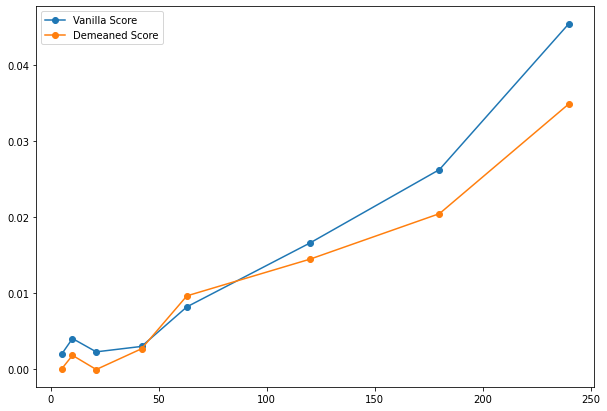

In [136]:
plt.figure(figsize=(10,7))
plt.plot(risk_factor_df1.iloc[:,0],risk_factor_df1.iloc[:,1], "-o", label='Vanilla Score')
plt.plot(risk_factor_df2.iloc[:,0],risk_factor_df2.iloc[:,1], "-o", label='Demeaned Score')
plt.legend()
plt.show()

# Ignore Below

In [ ]:
full_doc = pd.DataFrame([[5, 0.535430547972159],
 [10, 0.7173643146428407],
 [21, 1.0177421552340005],
 [42, 2.220874912438827],
 [63, 2.5742799677828248],
 [120, 3.921418196148364],
 [180, 5.636690596218136],
 [240, 6.199490452253092]])

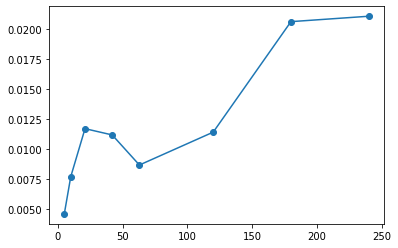

In [225]:
only1and7 = pd.DataFrame([[5, 0.4567963927381703],
 [10, 0.7687379071641265],
 [21, 1.1702252574171739],
 [42, 1.1176402982629752],
 [63, 0.866016068130335],
 [120, 1.1412793719014425],
 [180, 2.065690309102333],
 [240, 2.1108946097103853]])
plt.plot(only1and7[0], only1and7[1]/100, '-o')

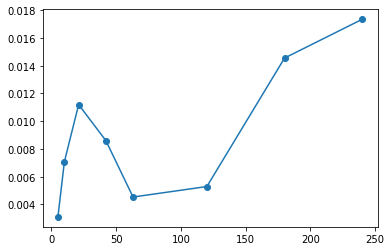

In [226]:
# Here is the dataframe from only item 7:
only7 = pd.DataFrame([[5, 0.310111],
[10, 0.708198],
[21, 1.119844],
[42, 0.860632],
[63, 0.453400],
[120, 0.529182],
[180, 1.455424],
[240, 1.735083]])
plt.plot(only7[0], only7[1]/100, '-o')

In [227]:
risk_factor_df

NameError: name 'risk_factor_df' is not defined

KeyError: 0

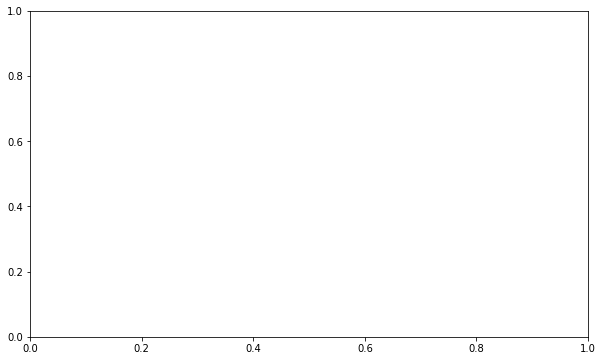

In [332]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
plt.plot(risk_factor_df1[0],risk_factor_df1[1], "-o", label='Whole Document w/ Cluster Demeaned')
plt.xlabel("Signal Horizon (in Days)")
plt.ylabel("Correlation to Ranked Returns")

fmt = '%.2f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

for i, txt in enumerate(risk_factor_df1.values):
    if i in [0,1,2,3,4,5]:
        plt.annotate(horizon_list[i], (risk_factor_df1[0][i]-4, risk_factor_df1[1][i]+0.25))
    elif i == 6:
        plt.annotate(horizon_list[i], (risk_factor_df1[0][i]-0.5, risk_factor_df1[1][i]+0.4))
    else:
        plt.annotate(horizon_list[i], (risk_factor_df1[0][i]+2, risk_factor_df1[1][i]+0.10))
plt.plot(full_doc[0], full_doc[1], '-o', label='Whole Document')
plt.plot(only1and7[0], only1and7[1], '-o', label='Items 1A and 7')
plt.plot(only7[0], only7[1], '-o', label='Item 7 Only')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.35))
plt.show()

# Project Continues Here

In [137]:
ranks = ranked_vanilla_score - 1/2
score = ranks.divide(ranks.count(axis=1), axis=0)
predictor = 2 * score - 1
predictor = predictor.divide(predictor.abs().sum(axis=1),axis=0).copy()

ranks2 = ranked_clustered_score - 1/2
score2 = ranks2.divide(ranks2.count(axis=1), axis=0)
predictor2 = 2 * score2 - 1
predictor2 = predictor2.divide(predictor2.abs().sum(axis=1),axis=0).copy()

In [138]:
#returns = rets.iloc[:,rets.columns.isin(ranks.columns)]
returns = rets.loc[:,ranks.columns] 

In [139]:
returns = returns.loc[:,[x for x in returns.columns if x not in badslist]]

In [140]:
leverage = 5

In [141]:
strat_returns = (predictor * leverage * returns.shift(-1)).sum(axis=1)
strat_returns2 = (predictor2 * leverage * returns.shift(-1)).sum(axis=1)
#strat_returns3 = (predictor3 * leverage * returns.shift(-1)).sum(axis=1)

In [142]:
#predictor.to_csv('predictor.csv')
#predictor2.to_csv('predictor2.csv')

In [143]:
pnl = strat_returns.cumsum()
pnl2 = strat_returns2.cumsum()
#pnl3 = strat_returns3.cumsum()

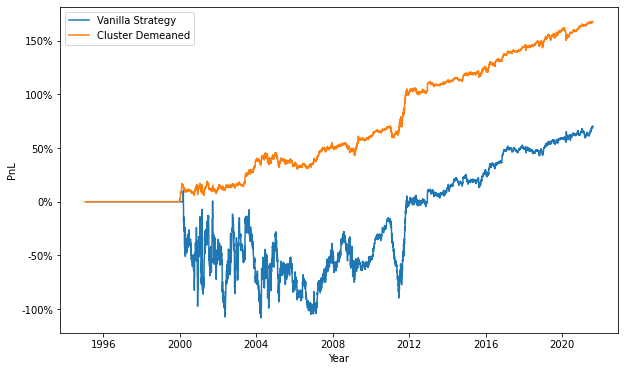

In [144]:
fig, ax = plt.subplots(figsize=(10,6))
#plt.figure(figsize=(10,6))
plt.xlabel("Year")
plt.ylabel("PnL")

plt.plot(pnl * 100, label='Vanilla Strategy')
plt.plot(pnl2 * 100, label='Cluster Demeaned')

#plt.plot(pnl3, label='Demeaned + Annual Rebalance')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
plt.legend()

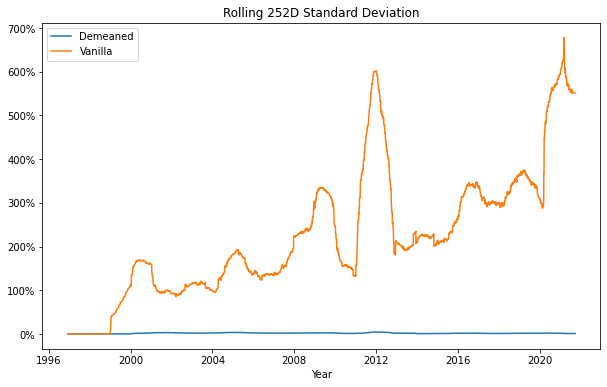

In [199]:
fig, ax = plt.subplots(figsize=(10,6))
plt.xlabel("Year")
plt.title("Rolling 252D Standard Deviation")
#strat_returns.rolling(252).std().plot()
plt.plot(strat_returns2.rolling(252).std().dropna() *np.sqrt(252) * 100 , label='Demeaned') 
plt.plot(strat_returns.rolling(252).std().dropna() *np.sqrt(252) * 100, label='Vanilla') 

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
#plt.plot(pd.DataFrame([strat_returns2.rolling(252).std().mean()]*len(strat_returns2.rolling(252).std()),
#                     index = strat_returns2.rolling(252).std().index), label='mean=0.00161')
plt.legend()

In [86]:
(strat_returns2.mean()/strat_returns2.std() * np.sqrt(252))

0.2992660246032343

In [87]:
(strat_returns.mean()/strat_returns.std() * np.sqrt(252))

0.28494827822587054

In [81]:
duration = len(pnl2.dropna().loc["1997-9-21":]) / 252

In [82]:
(1 + pnl2[-1])**(1/duration) - 1

0.06092882787602094

In [83]:
(1+0.06092882787602094)**duration - 1

3.111721575930213

In [84]:
(1 + pnl[-1]) ** (1/(duration))-1

0.050418638304922325

In [85]:
(1+0.0504186383049223)**duration - 1

2.240884421266265

In [86]:
strat_returns2.rolling(252).std().mean() * np.sqrt(252)

0.12795791509395654

In [223]:
strat_returns.rolling(252).std().mean() * np.sqrt(252)

0.12567642277246963

In [407]:
bad3 = returns["2007-02-20":"2007-02-27"].dropna(how='all',axis=1)

In [408]:
bad3[bad3 > 1].dropna(how='all',axis=1).dropna(how='all',axis=0)

,TEK
2007-02-26,35.693286


<AxesSubplot:>

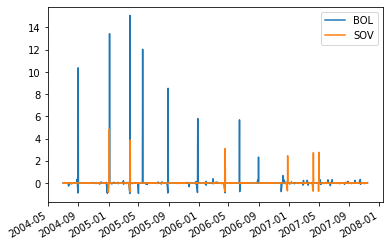

In [346]:
returns.loc[:,['BOL', 'SOV']].dropna().plot()

# Find Bad Data Points

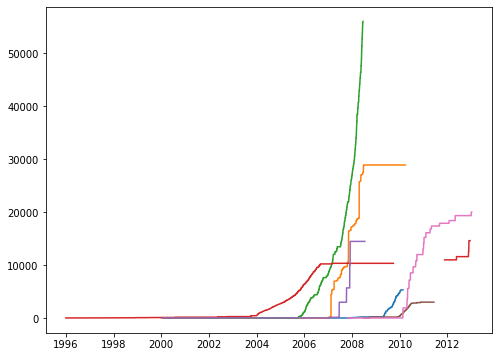

In [61]:
plt.figure(figsize=(8,6))
plt.plot(rets.iloc[:,np.abs([x for x in rets.fillna(0).cumsum().ffill().iloc[-1]]) > 500].cumsum())

In [245]:
bads = rets.iloc[:,np.abs([x for x in rets.fillna(0).cumsum().ffill().iloc[-1]]) > 500]
bads

,ACS,BDK,BSC,CBE,CFC,MEE,TIE
1996-01-02,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1996-01-03,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1996-01-04,NaN,NaN,NaN,0.045415,NaN,NaN,NaN
1996-01-05,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1996-01-08,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
rets.loc[:,'ACS'].dropna()

2004-04-02    0.000000
2004-04-05    0.000000
2004-04-06   -0.061538
2004-04-07    0.000000
2004-04-08    0.000000
                ...   
2010-02-16   -0.031987
2010-02-17    0.024348
2010-02-18    0.000000
2010-02-19    0.000000
2010-02-22   -0.016129
Name: ACS, Length: 1483, dtype: float64

No wonder,.... https://finance.yahoo.com/quote/ACS/history?period1=1262304000&period2=1269388800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [239]:
rets.loc[:,'BDK'].dropna()

2000-01-04   -0.011364
2000-01-05   -0.011494
2000-01-06    0.000000
2000-01-07    0.000000
2000-01-10   -0.011628
                ...   
2010-03-25   -0.010858
2010-03-26   -0.003293
2010-03-29   -0.005507
2010-03-30   -0.006644
2010-03-31   -0.003902
Name: BDK, Length: 2578, dtype: float64

https://finance.yahoo.com/quote/BDK/history?period1=1230768000&period2=1269993600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

<AxesSubplot:>

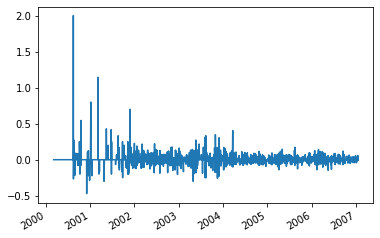

In [241]:
rets.loc[:,'BLS'].dropna().plot()

https://finance.yahoo.com/quote/BLS/history?period1=965088000&period2=967766400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [32]:
rets.loc[:,'BSC'].dropna()

2000-02-08       0.074304
2000-02-09       0.000000
2000-02-10       0.000000
2000-02-11       0.000000
2000-02-14       0.000000
                 ...     
2008-06-12    1033.084651
2008-06-13      -0.999107
2008-06-16    1159.529226
2008-06-17      -0.022522
2008-06-18       0.061656
Name: BSC, Length: 2105, dtype: float64

https://finance.yahoo.com/quote/BSC/history?period1=1167609600&period2=1230768000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [33]:
rets.loc[:,'CBE'].dropna()

1996-01-02    0.000000
1996-01-03    0.000000
1996-01-04    0.045415
1996-01-05    0.000000
1996-01-08    0.000000
                ...   
2012-12-11    0.000000
2012-12-12    0.000000
2012-12-13   -0.066667
2012-12-14    0.000000
2012-12-17   -0.071429
Name: CBE, Length: 3730, dtype: float64

https://finance.yahoo.com/quote/CBE/history?period1=1293840000&period2=1356998400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [34]:
rets.loc[:,'CFC'].dropna()

2000-01-20    0.000000
2000-01-21    0.000000
2000-01-24    0.000000
2000-01-25    0.000000
2000-01-26    0.000000
                ...   
2008-07-14   -0.017391
2008-07-15    0.000000
2008-07-16   -0.017699
2008-07-17    0.000000
2008-07-18   -0.018018
Name: CFC, Length: 2139, dtype: float64

https://finance.yahoo.com/quote/CFC/history?period1=1167609600&period2=1230768000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [35]:
rets.loc[:,'MEE'].dropna()

2008-06-23    0.039505
2008-06-24    0.214433
2008-06-25    0.037297
2008-06-26   -0.185437
2008-06-27    0.030094
                ...   
2011-06-06    0.000000
2011-06-07   -0.073037
2011-06-08    0.000000
2011-06-09    0.000000
2011-06-10    0.006063
Name: MEE, Length: 749, dtype: float64

https://finance.yahoo.com/quote/MEE/history?period1=1262304000&period2=1325376000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [36]:
rets.loc[:,'TIE'].dropna()

2007-10-29    0.002785
2007-10-30   -0.040000
2007-10-31    0.018519
2007-11-01   -0.035796
2007-11-02   -0.060401
                ...   
2013-01-04    0.018182
2013-01-07    0.000000
2013-01-08   -0.017857
2013-01-09   -0.045455
2013-01-10    0.028571
Name: TIE, Length: 1310, dtype: float64

https://finance.yahoo.com/quote/TIE/history?period1=1325376000&period2=1388534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

Jan 27, 2012


In [37]:
rets.loc[:,'TEK'].dropna()

2003-03-28    0.000000
2003-03-31    0.000000
2003-04-01    0.000000
2003-04-02    0.000000
2003-04-03    0.000000
                ...   
2007-11-27   -0.058825
2007-11-28    0.000000
2007-11-29    0.062501
2007-11-30   -0.058825
2007-12-03   -0.062501
Name: TEK, Length: 1181, dtype: float64

https://finance.yahoo.com/quote/TEK/history?period1=1170288000&period2=1172707200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [38]:
sum((predictor.mean(axis=1) > 0).values)

4871

In [242]:
sum((predictor.mean(axis=1) < 0).values)

0

In [163]:
pd.concat([strat_returns,strat_returns2],axis=1).to_csv("portfolio_returns.csv")

In [160]:
strat_returns2

1996-01-02    0.000000
1996-01-03    0.000000
1996-01-04    0.000000
1996-01-05    0.000000
1996-01-08    0.000000
                ...   
2021-08-03   -0.000165
2021-08-04   -0.000901
2021-08-05    0.000608
2021-08-06    0.000000
2021-08-10    0.000000
Length: 6460, dtype: float64

<AxesSubplot:>

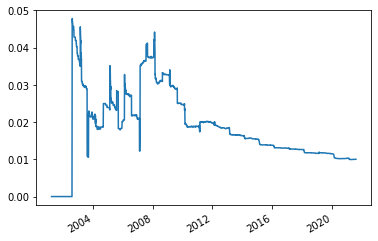

In [40]:
predictor.mean(axis=1).plot()

In [367]:
spy = pd.read_csv('1-SPY.csv').set_index('Date')

In [368]:
spy.pct_change()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,0.015267,0.005783,0.010698,0.002766,0.002767,0.186431
1996-01-04,0.000752,0.002000,-0.012601,-0.009529,-0.009528,0.851057
1996-01-05,-0.017280,-0.013972,-0.000766,-0.002025,-0.002025,-0.732318
1996-01-08,0.008155,0.002530,0.009195,0.003805,0.003805,-0.405093
...,...,...,...,...,...,...
2021-07-30,-0.004343,-0.003938,-0.004638,-0.004856,-0.004856,0.452307
2021-08-02,0.005549,0.001977,-0.001279,-0.002098,-0.002098,-0.146715
2021-08-03,-0.004315,0.000794,-0.002539,0.008135,0.008135,-0.012408


In [369]:
spy_rets = spy.pct_change()['Close']

In [370]:
spy_rets['1996-01-02'] = 0
spy_cumsum = spy_rets.cumsum()
spy_cumsum.index = pd.to_datetime(spy_cumsum.index)
spy_cumsum

Date
1996-01-02    0.000000
1996-01-03    0.002766
1996-01-04   -0.006763
1996-01-05   -0.008788
1996-01-08   -0.004983
                ...   
2021-07-30    2.446133
2021-08-02    2.444035
2021-08-03    2.452171
2021-08-04    2.447252
2021-08-05    2.453585
Name: Close, Length: 6444, dtype: float64

In [371]:
pd.concat([pnl, spy_cumsum])

1996-01-02    0.000000
1996-01-03    0.000000
1996-01-04    0.000000
1996-01-05    0.000000
1996-01-08    0.000000
                ...   
2021-07-30    2.446133
2021-08-02    2.444035
2021-08-03    2.452171
2021-08-04    2.447252
2021-08-05    2.453585
Length: 12904, dtype: float64

NameError: name 'j' is not defined

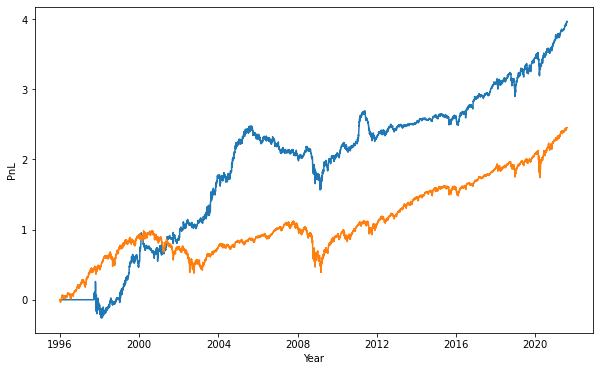

In [372]:
plt.figure(figsize=(10,6))
plt.xlabel("Year")
plt.ylabel("PnL")
plt.plot(pnl, label='Cosine Distance')
plt.plot(spy_cumsum, label='Benchmark (S&P 500)')
plt.plot([returns.iloc[i].name, returns.iloc[j].name], 
         [pnl.iloc[i], pnl.iloc[j]], 'o', color='Red', markersize=5)
plt.legend()
plt.show()

In [47]:
returns.iloc[i].name

NameError: name 'i' is not defined

In [48]:
pnl.iloc[-1]

131.0808743483531

In [49]:
spy_cumsum.iloc[-1]

2.4535846041524847

In [98]:
x = strat_returns.fillna(0)
y = strat_returns2.fillna(0)
#y.index = pd.to_datetime(y.index)

In [99]:
min(x)

-0.010994019067175056

In [100]:
min(y)

-0.010879378601066508

In [53]:
(beta, alpha) = stats.linregress(x,y)[0:2]

In [54]:
print("The portfolio beta is", round(beta, 4))

The portfolio beta is -0.0015


In [55]:
strat_returns[strat_returns.index.isin(spy_rets.index)].values,spy_rets.values

(array([ 0.        ,  0.        ,  0.        , ...,  0.2657975 ,
        -0.03934448,  0.05076001]),
 array([ 0.        ,  0.0027659 , -0.00952859, ...,  0.00813546,
        -0.00491892,  0.00633286]))

In [56]:
strat_returns[strat_returns.index.isin(spy_rets.index)]

1996-01-02    0.000000
1996-01-03    0.000000
1996-01-04    0.000000
1996-01-05    0.000000
1996-01-08    0.000000
                ...   
2021-07-30    0.197862
2021-08-02    0.009391
2021-08-03    0.265797
2021-08-04   -0.039344
2021-08-05    0.050760
Length: 6444, dtype: float64

In [152]:
x.cumsum().mean()/x.cumsum().std() * np.sqrt(252)

27.677934240849538

In [102]:
y.mean()/y.std() * np.sqrt(252)

0.915207521763342

<AxesSubplot:>

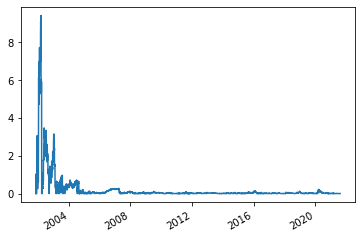

In [59]:
(( np.maximum.accumulate(pnl) - pnl) / np.maximum.accumulate(pnl)).plot()

# Max Drawdown of PnL

In [308]:
i = np.argmax(np.maximum.accumulate(pnl2) - pnl2) # end of the period
j = np.argmax(pnl2[:i]) # start of period

In [309]:
rets.iloc[i]

A        0.038461
AABA          NaN
AAL           NaN
AAMRQ         NaN
AAP           NaN
           ...   
YUM      0.020221
ZBH           NaN
ZBRA          NaN
ZION          NaN
ZTS           NaN
Name: 2000-12-07 00:00:00, Length: 1110, dtype: float64

In [310]:
rets.iloc[j]

A             NaN
AABA          NaN
AAL           NaN
AAMRQ         NaN
AAP           NaN
           ...   
YUM      0.004184
ZBH           NaN
ZBRA          NaN
ZION          NaN
ZTS           NaN
Name: 2000-02-09 00:00:00, Length: 1110, dtype: float64

In [311]:
(pnl2.iloc[j] - pnl2.iloc[i])/pnl2.iloc[j]

0.4707752398309481

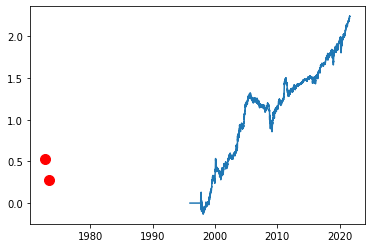

In [312]:
plt.plot(pnl)
plt.plot([i, j], [pnl.iloc[i], pnl.iloc[j]], 'o', color='Red', markersize=10)

# Max Drawdown of PnL

In [313]:
i = np.argmax(np.maximum.accumulate(spy_cumsum) - spy_cumsum) # end of the period
j = np.argmax(spy_cumsum[:i]) # start of period

NameError: name 'spy_cumsum' is not defined

In [66]:
spy.iloc[i]

Open         6.795000e+01
High         7.000000e+01
Low          6.773000e+01
Close        6.811000e+01
Adj Close    5.315531e+01
Volume       3.799053e+08
Name: 2009-03-09, dtype: float64

In [67]:
spy.iloc[j]

Open         1.556000e+02
High         1.565000e+02
Low          1.550300e+02
Close        1.564800e+02
Adj Close    1.186223e+02
Volume       9.405430e+07
Name: 2007-10-09, dtype: float64

In [68]:
(spy_cumsum.iloc[j] - spy_cumsum.iloc[i])/spy_cumsum.iloc[j]

0.6515065316657538

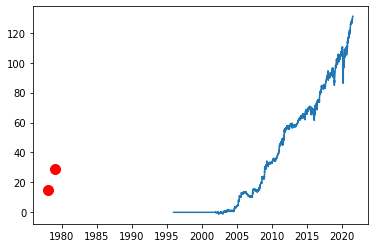

In [69]:
plt.plot(pnl)
plt.plot([i, j], [pnl.iloc[i], pnl.iloc[j]], 'o', color='Red', markersize=10)

In [70]:
dd.plot()

NameError: name 'dd' is not defined

In [317]:
highwatermarks = pnl2.cummax()
drawdowns = (1 + highwatermarks)/(1 + pnl2) - 1
max_drawdown = max(drawdowns)
max_drawdown

0.2621270007304779

<AxesSubplot:>

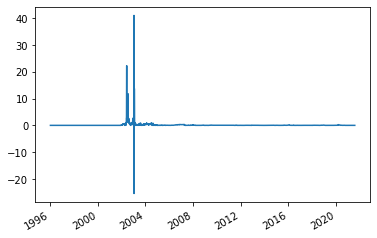

In [72]:
drawdowns.plot()

In [73]:
list(drawdowns).index(max_drawdown)

1773

In [74]:
returns.iloc[1773]

AAL          NaN
AAP          NaN
AAPL   -0.001367
ABBV         NaN
ABC    -0.009253
          ...   
YRCW         NaN
YUM     0.023800
ZBRA         NaN
ZION    0.002798
ZTS          NaN
Name: 2003-01-14 00:00:00, Length: 865, dtype: float64

<AxesSubplot:>

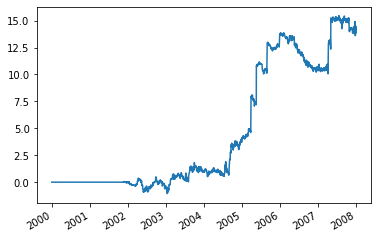

In [75]:
pnl["2000-01-01":"2008-01-01"].plot()

In [76]:
def calc_beta(df):
    np_array = df.values
    s = np_array[:,0] 
    m = np_array[:,1]

    covariance = np.cov(s,m) 
    beta = covariance[0,1]/covariance[1,1]
    return beta

def rolling(df, period, function , min_periods=None):
    if min_periods is None:
        min_periods = period
    result = pd.Series(np.nan, index=df.index)

    for i in range(1, len(df)+1):
        df2 = df.iloc[max(i-period, 0):i,:] #I edited here
        if len(df2) >= min_periods:
            idx = df2.index[-1]
            result[idx] = function(df2)
    return result

In [77]:
data = pd.DataFrame([x.values,y.values], columns=x.index, index = ['strat','spy']).T
data.head()

,strat,spy
1996-01-02,0.0,0.000000
1996-01-03,0.0,0.002766
1996-01-04,0.0,-0.009529
1996-01-05,0.0,-0.002025
1996-01-08,0.0,0.003805


<AxesSubplot:>

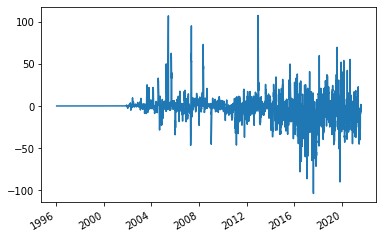

In [101]:
rolling(data, 12, calc_beta, min_periods=None).plot()

In [102]:
betalist = []
period= 252
for i in range(period,len(x)):
    print(i)
    one = x.fillna(0).iloc[i-period:i].values
    two = y.fillna(0).iloc[i-period:i].values
    try:
        betalist.append(stats.linregress(one,two)[0])
    except:
        continue

252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430


/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680


2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467


3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159


5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905


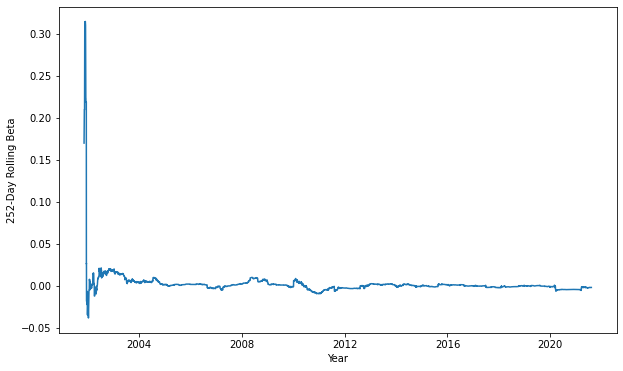

In [305]:
plt.figure(figsize=(10,6))
plt.ylabel('252-Day Rolling Beta')
plt.xlabel('Year')
plt.plot(pd.DataFrame(betalist, index=x.index[252:], columns=['Rolling Beta']))
plt.show()

In [104]:
x.iloc[i:i+period]

2021-08-05    0.05076
dtype: float64

# Calculate Turnover

In [149]:
len(b) - sum((b.fillna(0).diff() == 0).all(axis=1))

1765

In [151]:
turnovers = pnl.index.isin(scores_df.dropna(how='all').index) * 1
sum(turnovers)

1856

In [121]:
plotlist = [np.nan if turnovers[i] == 0 else pnl2[i] for i in range(len(turnovers))]
plotlist.count(0)

8

In [122]:
pnl2

1996-01-02    0.000000
1996-01-03    0.000000
1996-01-04    0.000000
1996-01-05    0.000000
1996-01-08    0.000000
                ...   
2021-08-03    0.622637
2021-08-04    0.621736
2021-08-05    0.622344
2021-08-06    0.622344
2021-08-10    0.622344
Length: 6460, dtype: float64

In [123]:
pnl2.index

DatetimeIndex(['1996-01-02', '1996-01-03', '1996-01-04', '1996-01-05',
               '1996-01-08', '1996-01-09', '1996-01-10', '1996-01-11',
               '1996-01-12', '1996-01-15',
               ...
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-10'],
              dtype='datetime64[ns]', length=6460, freq=None)

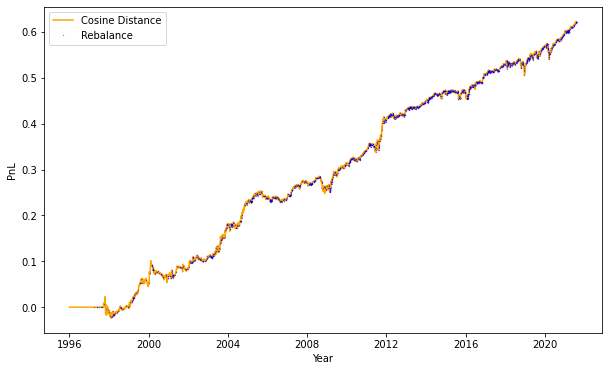

In [124]:
plt.figure(figsize=(10,6))
plt.xlabel("Year")
plt.ylabel("PnL")
plt.plot(pnl2, label='Cosine Distance', color='orange')
plt.plot(b.index, 
         plotlist, 'o', color='blue', markersize=0.2, label='Rebalance')
plt.legend()
plt.show()

In [267]:
b.index

DatetimeIndex(['1996-01-02', '1996-01-03', '1996-01-04', '1996-01-05',
               '1996-01-08', '1996-01-09', '1996-01-10', '1996-01-11',
               '1996-01-12', '1996-01-15',
               ...
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-10'],
              dtype='datetime64[ns]', length=6459, freq=None)

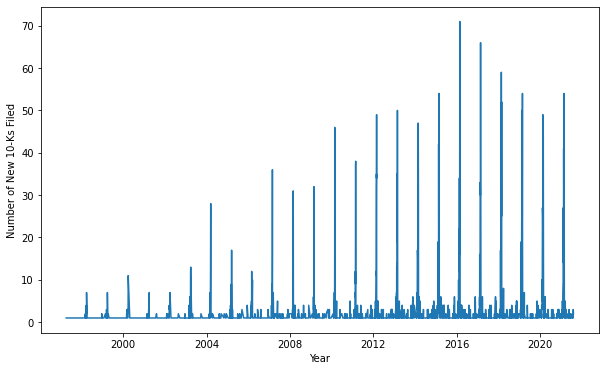

In [125]:
plt.figure(figsize=(10,6))
plt.ylabel('Number of New 10-Ks Filed')
plt.xlabel('Year')
plt.plot(scores_df.dropna(how='all').count(axis=1))

# Rolling Sharpe Ratio

In [453]:
sharpelist = []
period= 252
for i in range(period,len(pnl)):
    print(i)
    one = strat_returns.iloc[i-period:i].values
    sharpelist.append(one.mean() / one.std())

252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501


/Users/lucaskrenn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  



1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301

3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383


5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293


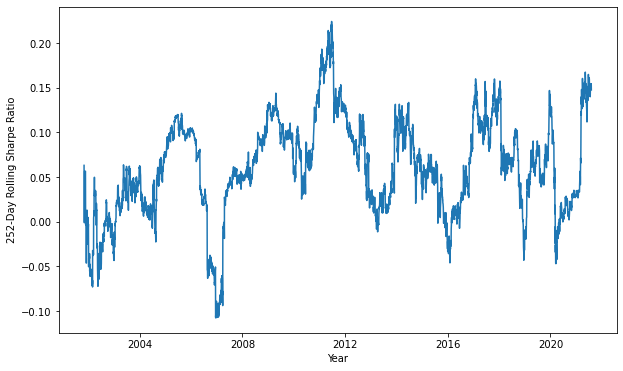

In [314]:
plt.figure(figsize=(10,6))
plt.ylabel('252-Day Rolling Sharpe Ratio')
plt.xlabel('Year')
plt.plot(pd.DataFrame(sharpelist, index=x.index[252-15:], columns=['Rolling Beta']))
plt.show()

In [322]:
b.mean()

AAL     119.457721
AAP     382.821867
AAPL    571.151693
ABBV    366.049311
ABC     361.507716
           ...    
YRCW    248.511111
YUM     359.745794
ZBRA    195.734186
ZION    520.763218
ZTS     690.320058
Length: 873, dtype: float64

In [319]:
list(b.mean()).index(max(b.mean()))

839

In [326]:
b.mean().sort_values(ascending=False)

WFC      840.820513
BK       836.554535
PFG      818.450736
STT      808.800539
PGR      807.718611
            ...    
SAF             NaN
TFC             NaN
VSTNQ           NaN
WB              NaN
WYND            NaN
Length: 873, dtype: float64

In [332]:
len(b.iloc[5000].dropna().values)

722

In [333]:
pnl

1996-01-02      0.000000
1996-01-03      0.000000
1996-01-04      0.000000
1996-01-05      0.000000
1996-01-08      0.000000
                 ...    
2021-08-03    131.069459
2021-08-04    131.030114
2021-08-05    131.080874
2021-08-06    131.080874
2021-08-10    131.080874
Length: 6459, dtype: float64

In [334]:
strat_returns

1996-01-02    0.000000
1996-01-03    0.000000
1996-01-04    0.000000
1996-01-05    0.000000
1996-01-08    0.000000
                ...   
2021-08-03    0.265797
2021-08-04   -0.039344
2021-08-05    0.050760
2021-08-06    0.000000
2021-08-10    0.000000
Length: 6459, dtype: float64

# Fixing Leverage

In [257]:
leverage = 1

In [258]:
predictor2 = predictor.divide(predictor.abs().sum(axis=1),axis=0)

<AxesSubplot:>

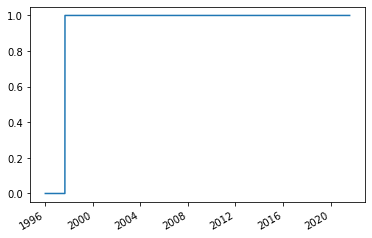

In [259]:
predictor2.abs().sum(axis=1).plot()

In [260]:
returns = rets.iloc[:,rets.columns.isin(ranks.columns)]
#returns = rets.loc[:,ranks.columns]

In [265]:
returns = returns.loc[:,[x for x in returns.columns if x not in badslist]]

In [266]:
strat_returns = (predictor2 * leverage * returns.shift(-1)).sum(axis=1)

<AxesSubplot:>

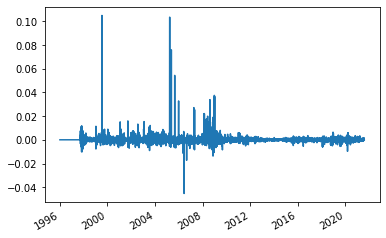

In [267]:
strat_returns.plot()

<AxesSubplot:>

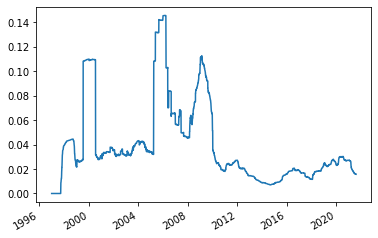

In [268]:
(strat_returns.rolling(252).std() * np.sqrt(252)).plot()

In [269]:
pnl2 = strat_returns.cumsum()

<AxesSubplot:>

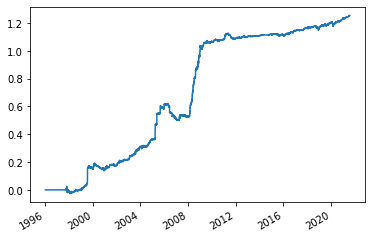

In [270]:
# Compare volatility
# Place a bar when the paper was published
pnl2.plot()

In [281]:
pnl2[pnl2.pct_change() > 3]

1997-09-22    0.007519
1997-10-29   -0.012663
1998-07-27    0.002545
1998-11-10    0.001382
dtype: float64

In [285]:
pnl2["1999-07-01":"1999-08-01"]

1999-07-01    0.045197
1999-07-02    0.047307
1999-07-06    0.048508
1999-07-07    0.046793
1999-07-08    0.046872
1999-07-09    0.047219
1999-07-12    0.046696
1999-07-13    0.048137
1999-07-14    0.047984
1999-07-15    0.049487
1999-07-16    0.154334
1999-07-19    0.154907
1999-07-20    0.154668
1999-07-21    0.157142
1999-07-22    0.157024
1999-07-23    0.156288
1999-07-26    0.158464
1999-07-27    0.158181
1999-07-28    0.158184
1999-07-29    0.157292
1999-07-30    0.157077
dtype: float64

In [286]:
bads2 = returns["1999-07-15":"1999-07-16"].dropna(how='all',axis=1)

In [299]:
bads2.sum(axis=1)

1999-07-15    0.899556
1999-07-16    0.956581
dtype: float64

We want to design our portfolio such that our returns are 1-sigma i.e. the rolling volatility is close to 1:

<AxesSubplot:>

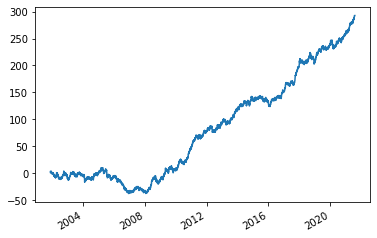

In [105]:
(strat_returns / strat_returns.rolling(10).std()).cumsum().plot()

In [106]:
strat_returns.rolling(10).std()

1996-01-02         NaN
1996-01-03         NaN
1996-01-04         NaN
1996-01-05         NaN
1996-01-08         NaN
                ...   
2021-08-03    0.000643
2021-08-04    0.000650
2021-08-05    0.000421
2021-08-06    0.000381
2021-08-10    0.000395
Length: 6459, dtype: float64

In [265]:
spy_rets

Date
1996-01-02    0.000000
1996-01-03    0.002766
1996-01-04   -0.009529
1996-01-05   -0.002025
1996-01-08    0.003805
                ...   
2021-07-30   -0.004856
2021-08-02   -0.002098
2021-08-03    0.008135
2021-08-04   -0.004919
2021-08-05    0.006333
Name: Close, Length: 6444, dtype: float64